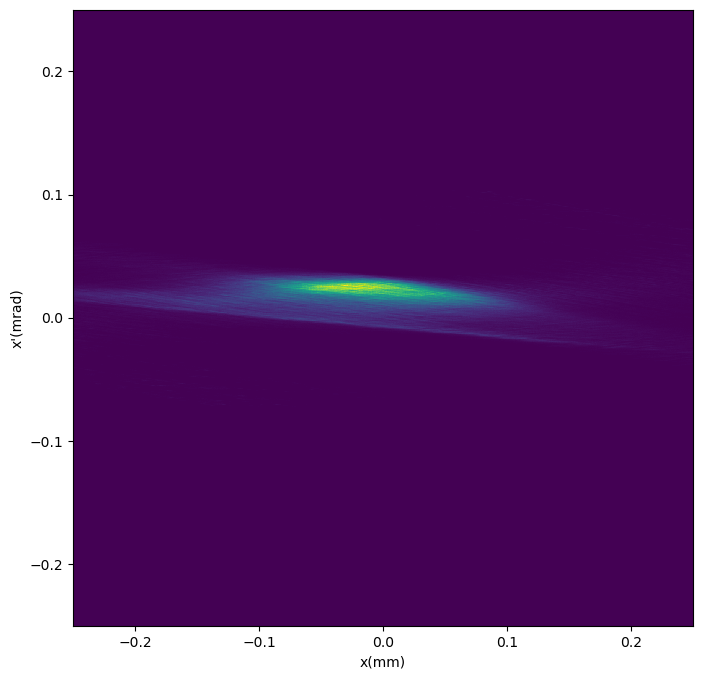

In [1]:
from UTILITY_quickstart import *
import pickle

with open('/Users/nmajik/Downloads/phase_space_sector_15.pkl', 'rb') as f:
    histogram_data_load = pickle.load(f)
counts = histogram_data_load['hist_x'] # or hist_y
edges = histogram_data_load['edges']
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(edges, edges, counts.T)
ax.set_xlabel('x(mm)')
ax.set_ylabel("x'(mrad)")
plt.show()

In [2]:
histogram_data_load

{'hist_x': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'hist_y': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'edges': array([-0.25  , -0.2495, -0.249 , ...,  0.249 ,  0.2495,  0.25  ])}

In [3]:
import pandas as pd 
df = pd.DataFrame(histogram_data_load["hist_x"])
df.to_csv("./reconstruction_X.csv", header=False, index=False)

df = pd.DataFrame(histogram_data_load["hist_y"])
df.to_csv("./reconstruction_Y.csv", header=False, index=False)

## Dumping ground truth

From "2025-02-26 BC14 data for Yiheng.ipynb"

In [4]:
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline.yml")

In [5]:
csrTF = True


bunchCount = importedDefaultSettings["bunchCount"]

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    
    csrTF = csrTF,
    numMacroParticles=1e5,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)
launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Beam created, written to /tmp/beams/activeBeamFile_12285705193529358360.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [28.77872199 13.3970811  23.51278494 16.8307956 ]
Objective Function Value at Optimal Parameters: 9.505958617749993e-12
Number of Iterations: 260
Converged: True


In [6]:
trackStart = "ENDBC14E"
trackEnd = "PR15944"

trackBeam(tao, trackEnd = trackStart, **importedDefaultSettings)

PStart = getBeamAtElement(tao, trackStart)

makeBeamActiveBeamFile( PStart, tao = tao )

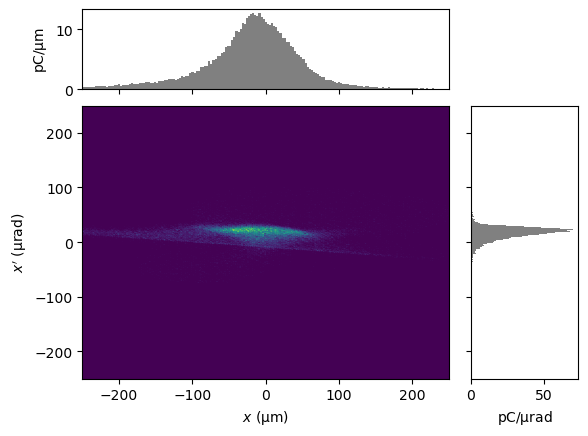

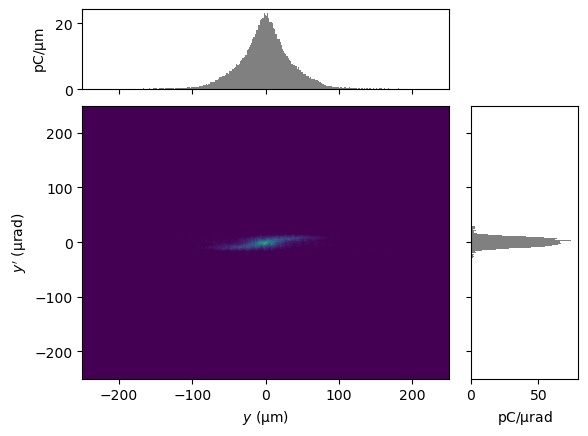

In [7]:
display(plotMod(PStart, 'x', 'xp', bins=1000, xlim = (-0.25e-3, 0.25e-3), ylim = (-0.25e-3,0.25e-3)))
display(plotMod(PStart, 'y', 'yp', bins=1000, xlim = (-0.25e-3, 0.25e-3), ylim = (-0.25e-3,0.25e-3)))
plt.clf()

In [8]:
PStart.write("2025-03-25_groundTruth.h5")

## Import and compare reconstruction population

In [15]:
print( 1e6 * PStart.twiss(plane = "x")["norm_emit_x"] )
print( 1e6 * PStart.twiss(plane = "x", fraction = 0.9)["norm_emit_x"] )
print( 1e6 * smallestIntervalImpliedEmittance(PStart) )

print( 1e6 * PStart.twiss(plane = "y")["norm_emit_y"] )
print( 1e6 * PStart.twiss(plane = "y", fraction = 0.9)["norm_emit_y"] )
print( 1e6 * smallestIntervalImpliedEmittance(PStart, plane = "y") )

14.743965673669708
5.244261257818355
9.230924691259245
4.618491958406398
1.6065554173553143
2.8382308760279886


In [16]:
PRecons = PStart.copy()

numParticles = len(PStart.x)
numParticles

99978

In [17]:
df = pd.read_csv('/Users/nmajik/reconstruction_X.csv', sep=',', header=None)
xData = np.array(df)

df = pd.read_csv('/Users/nmajik/reconstruction_Y.csv', sep=',', header=None)
yData = np.array(df)

xData

array([[-0.04512361, -0.00997452],
       [ 0.01026337,  0.0213702 ],
       [-0.10868462,  0.02644657],
       ...,
       [ 0.10047896,  0.01982167],
       [-0.02483585,  0.03152807],
       [-0.07652479,  0.01859245]])

In [18]:
#Multiply by 1e-3 since Yiheng works in mm and mrad

PRecons.x  = 1e-3 * xData[:numParticles, 0]
PRecons.px = 1e-3 * xData[:numParticles, 1] * PRecons.pz

PRecons.y  = 1e-3 * yData[:numParticles, 0]
PRecons.py = 1e-3 * yData[:numParticles, 1] * PRecons.pz

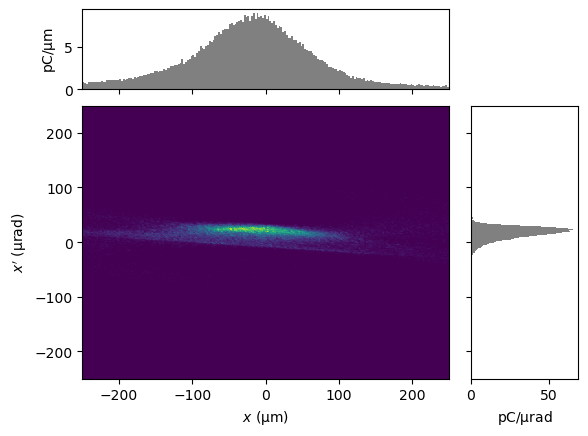

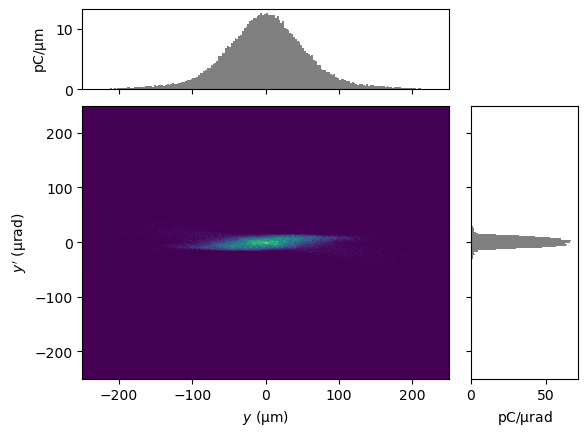

In [19]:
display(plotMod(PRecons, 'x', 'xp', bins=200, xlim = (-0.25e-3, 0.25e-3), ylim = (-0.25e-3,0.25e-3)))
display(plotMod(PRecons, 'y', 'yp', bins=200, xlim = (-0.25e-3, 0.25e-3), ylim = (-0.25e-3,0.25e-3)))
plt.clf()

In [20]:
print( 1e6 * PRecons.twiss(plane = "x")["norm_emit_x"] )
print( 1e6 * PRecons.twiss(plane = "x", fraction = 0.9)["norm_emit_x"] )
print( 1e6 * smallestIntervalImpliedEmittance(PRecons) )

print( 1e6 * PRecons.twiss(plane = "y")["norm_emit_y"] )
print( 1e6 * PRecons.twiss(plane = "y", fraction = 0.9)["norm_emit_y"] )
print( 1e6 * smallestIntervalImpliedEmittance(PRecons, plane = "y") )

10.086004385447781
6.489510968970822
8.707749188644774
5.757568418203644
2.697147265101612
4.19061473745899
